In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
from tensorflow import keras

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

drive.mount("/content/drive")
os.chdir("drive/MyDrive/Colab Notebooks/ML Project")
print("Current Working Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory: /content/drive/.shortcut-targets-by-id/1eFg-3udRfnN8OJhpS-vUwlyyGvxeGMy7/ML Project


In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7494612124284415834
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8598106282808437502
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
base_dir = 'chest_xray/'
train_dir = base_dir + 'train/'
test_dir = base_dir + 'test/'
train_normal = train_dir + 'NORMAL/'
train_pneumonia = train_dir + 'PNEUMONIA/'
test_normal = test_dir + 'NORMAL/'
test_pneumonia = test_dir + 'PNEUMONIA/'

In [4]:
print('Train Normal:', len(os.listdir(train_normal)))
print('Test Normal:', len(os.listdir(test_normal)))
print('Train Pneumonia:', len(os.listdir(train_pneumonia)))
print('Test Pneumonia:', len(os.listdir(test_pneumonia)))

Train Normal: 1350
Test Normal: 234
Train Pneumonia: 3885
Test Pneumonia: 390


In [5]:
train_data = ImageDataGenerator(rescale = 1./255, rotation_range = 40, shear_range = 0.2, zoom_range = 0.2, width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, fill_mode = 'nearest')
test_data = ImageDataGenerator(rescale = 1./255)

In [6]:
train_generator = train_data.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 32, class_mode = 'binary')
test_generator = test_data.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 32, class_mode = 'binary', shuffle = False)

Found 5235 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
cnn_base = VGG16(include_top = False, weights = 'imagenet', input_shape = (150, 150, 3), classes = 2, classifier_activation = 'sigmoid')
cnn_base.trainable = False
cnn_model = Sequential()
cnn_model.add(cnn_base)
cnn_model.add(Flatten())
cnn_model.add(Dense(640, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation = 'sigmoid'))
cnn_model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(0.0001), metrics = ['acc'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               5243520   
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [8]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1), ModelCheckpoint(filepath = 'vgg16_model.h5', monitor = 'val_loss', save_best_only = True)]
cnn_history = cnn_model.fit(train_generator, steps_per_epoch = 5235 // 32, epochs = 30, validation_data = test_generator, validation_steps = 624 // 32, callbacks = early_stopping)

Epoch 1/30
163/163 [==============================] - 92s 529ms/step - loss: 0.5098 - acc: 0.7614 - val_loss: 0.3452 - val_acc: 0.8684
Epoch 2/30
163/163 [==============================] - 84s 518ms/step - loss: 0.2798 - acc: 0.8776 - val_loss: 0.2914 - val_acc: 0.8766
Epoch 3/30
163/163 [==============================] - 84s 516ms/step - loss: 0.2322 - acc: 0.9017 - val_loss: 0.3163 - val_acc: 0.8816
Epoch 4/30
163/163 [==============================] - 84s 514ms/step - loss: 0.2292 - acc: 0.9115 - val_loss: 0.2971 - val_acc: 0.8947
Epoch 5/30
163/163 [==============================] - 84s 514ms/step - loss: 0.2143 - acc: 0.9160 - val_loss: 0.2603 - val_acc: 0.8980
Epoch 6/30
163/163 [==============================] - 84s 514ms/step - loss: 0.2036 - acc: 0.9149 - val_loss: 0.2459 - val_acc: 0.8997
Epoch 7/30
163/163 [==============================] - 84s 513ms/step - loss: 0.1916 - acc: 0.9267 - val_loss: 0.2525 - val_acc: 0.9128
Epoch 8/30
163/163 [==============================] - 8

In [9]:
cnn_model.save('vgg16_model.h5')

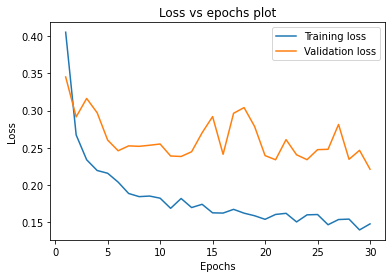

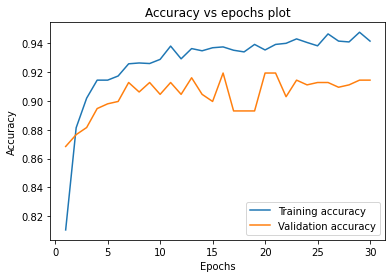

In [10]:
train_acc_list = cnn_history.history['acc']
train_loss_list = cnn_history.history['loss']
val_acc_list = cnn_history.history['val_acc']
val_loss_list = cnn_history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs plot')
plt.plot(list(range(1, len(train_loss_list) + 1)), train_loss_list, label = 'Training loss')
plt.plot(list(range(1, len(val_loss_list) + 1)), val_loss_list, label = 'Validation loss')
plt.legend()
plt.show()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs epochs plot')
plt.plot(list(range(1, len(train_acc_list) + 1)), train_acc_list, label = 'Training accuracy')
plt.plot(list(range(1, len(val_acc_list) + 1)), val_acc_list, label = 'Validation accuracy')
plt.legend()
plt.show()

In [11]:
y_pred = cnn_model.predict_classes(test_generator)
y_test = np.concatenate((np.zeros(234), np.ones(390)))
train_accuracy = cnn_model.evaluate(train_generator)[1]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


164/164 [==============================] - 79s 480ms/step - loss: 0.1276 - acc: 0.9484


In [12]:
mat = confusion_matrix(y_test, y_pred)
TN = mat[0][0]
TP = mat[1][1]
FN = mat[1][0]
FP = mat[0][1]
acc = (TN+TP)/(TN+TP+FN+FP)
recall = (TP)/(TP+FN)
specificity = (TN)/(TN+FP)
auc = roc_auc_score(y_test, y_pred)

print("Recall of test set:", recall)
print("Specificity of test set:", specificity)
print("Accuracy on test set:", acc)
print("AUC score of test set:", auc)
print("Accuracy of train set:", train_accuracy)

Recall of test set: 0.9333333333333333
Specificity of test set: 0.8888888888888888
Accuracy on test set: 0.9166666666666666
AUC score of test set: 0.911111111111111
Accuracy of train set: 0.9484240412712097


In [13]:
print('VGG16 CNN Model Classification Report', '\n', classification_report(y_test, y_pred, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

VGG16 CNN Model Classification Report 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.89      0.89      0.89       234
PNEUMONIA (Class 1)       0.93      0.93      0.93       390

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [14]:
!pip install --upgrade plotly==4.14.0
import plotly.express as plt2

def plot_cm(z, label_names):
    fig = plt2.imshow(z,
                     labels = dict(x = "Predicted", y = "Actual", color = "Productivity"),
                     x = label_names,
                     y = label_names,
                     width = 700)
    fig.update_layout(title = 'Confusion Matrix')
    fig.update_xaxes(side = "top")
    return fig

     |████████████████████████████████| 13.2MB 243kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [15]:
plot_cm(mat, ['NORMAL (Class 0)','PNEUMONIA (Class 1)']).show()

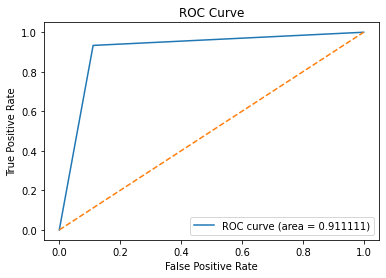

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = "lower right")
plt.show()